# Modelling a Bridge using 2D Truss Elements



## First I'll load the relevant python modules:

In [1]:
%matplotlib inline
import numpy as np
from helpfunctions_01d_Truss_Bridge import *


## The default / design space:

In [17]:
L,H = 3.,1.5 #meter
refine = 2


## The inital set of design parameters are initialised assuming equal spacing and fixed height

In [18]:
x0 = bridge_design(length=L,refine=refine,initialize=True,height=H)[0]
print(f'\n\tInitial design parameter values : {x0}')


	Initial design parameter values : [1.0, 0.5, 1.5, 1.5]


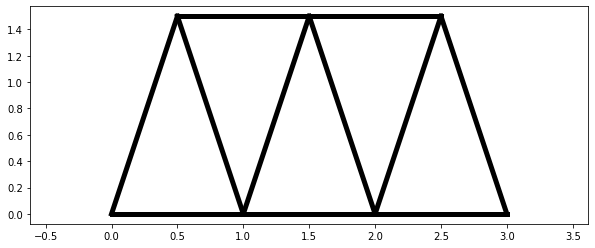

In [19]:
# plot the bridge:
x = x0#[1.0, 8.0, 2.0, 5.0, 6.0, 5.0, 8.0]
bridge_plot(x,length=L,refine=refine,height=H)



## CalculiX input file


Using the design parameter values

     (1) get the nodal coordinates and element connectivity
     (2) then write the CalculiX input file

In [7]:
# get coordinates and connectivity:
coords,elems = bridge_design(x,length=L,refine=refine)

# write to CCX file
ccxfile = 'bridgeEX'
bridge_CCX(coords,elems,fname=ccxfile)


# print to screens
print(open(ccxfile+'.inp').read())


**
**  MODEL A  SIMPLE BRIDGE USING
**  TWO NODE TRUSS ELEMENTS (T3D2)
**
**
*NODE,NSET=Nall
**
1, 0.000000, 0.000000, 0.000000
2, 2.000000, 5.000000, 0.000000
3, 4.000000, 0.000000, 0.000000
4, 6.000000, 5.000000, 0.000000
5, 8.000000, 0.000000, 0.000000
6, 10.000000, 5.000000, 0.000000
7, 12.000000, 0.000000, 0.000000
8, 14.000000, 5.000000, 0.000000
9, 16.000000, 0.000000, 0.000000
10, 18.000000, 5.000000, 0.000000
11, 20.000000, 0.000000, 0.000000
**
*ELEMENT,TYPE=T3D2,ELSET=EAll
**
1, 1, 2
2, 1, 3
3, 2, 3
4, 2, 4
5, 3, 4
6, 3, 5
7, 4, 5
8, 4, 6
9, 5, 6
10, 5, 7
11, 6, 7
12, 6, 8
13, 7, 8
14, 7, 9
15, 8, 9
16, 8, 10
17, 9, 10
18, 9, 11
19, 10, 11
**
*BOUNDARY
1,1,2,
11,1,2
NALL,3,3
*MATERIAL,NAME=STEEL
*ELASTIC
2E11,.3
*DENSITY
7830.
*SOLID SECTION,ELSET=EAll,MATERIAL=STEEL
2.5e-5
*STEP
*STATIC
*CLOAD
1, 2, -20000.000000
3, 2, -40000.000000
5, 2, -40000.000000
7, 2, -40000.000000
9, 2, -40000.000000
11, 2, -20000.000000
*DLOAD
EALL,GRAV,9.81,0.,-1.,0.
*EL PRINT,ELSET=Eall,FREQUENCY



# Solve using CalculiX


In [12]:
os.system('ccx '+ccxfile)

0




## Extract the stresses and displlacements from the *.dat file and plot

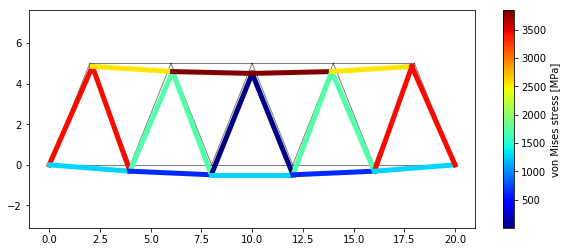

In [13]:
# extract
stress, displ = bridge_extract(ccxfile)
# plot
bridge_plot_results(coords,elems,stress,displ,overlay=True)

In [14]:

# maximum displacement and total steel length:
maxdisp = np.max(np.abs(displ[::2,1])) # in meter
print("\n\tMaximum displacement of interest : %.4f meter"%maxdisp)
total_Len = bridge_volume(coords,elems)
print("\n\tBridge uses a total of %.2f meter steel"%total_Len)


	Maximum displacement of interest : 0.4897 meter

	Bridge uses a total of 89.85 meter steel






## Construct an objective function and constraints

### 1. Minimize displacement subject to total allowable steel used

In [22]:
maxsteel = 100. #maximum allowable steel is 100m

allowable_displ = 1.

# Objective function
def objF1(x,printR=False,plotR=False):
    coords,elems = bridge_design(x,length=L,refine=refine)
    bridge_CCX(coords,elems,fname=ccxfile)
    os.system('ccx '+ccxfile+' >>/dev/null')
    stress, displ = bridge_extract(ccxfile)
    
    
    
    #FV = np.max(np.abs(displ[::2,1]))    
    #
    # simple penalty constraint 
    total_Len = bridge_volume(coords,elems)
    
    FV = total_Len
    #
    #if total_Len > maxsteel:
    #    FV += 100*(total_Len-maxsteel)**2
    
    maxdisp = np.max(np.abs(displ[::2,1]))
    
    if maxdisp > allowable_displ:
        FV += 1000*(allowable_displ-maxdisp)**2
        
    
    if printR: print( "FV: ",FV," Len: ",total_Len," X = ",x)
    if plotR: bridge_plot_results(coords,elems,stress,displ,overlay=True)
        
        
    return FV

print(f"\nObjective function value: {objF1(x)}")
    


Objective function value: 89.85164807134504


In [23]:
from scipy.optimize import fmin_slsqp
#xopt = fmin(objF1,x0,args=(True,False))
xopt = fmin_slsqp(objF1,x0,args=(True,False),epsilon=1e-4)
#xopt = [ 5.83052734,  3.4008745,   2.39325744,  3.1535875,   4.31396472,  4.73000857,  5.39330512]

FV:  89.8516480713  Len:  89.8516480713  X =  [ 4.  8.  2.  5.  6.  5.  5.]
FV:  89.8516480713  Len:  89.8516480713  X =  [ 4.  8.  2.  5.  6.  5.  5.]
FV:  89.8516480745  Len:  89.8516480745  X =  [ 4.0001  8.      2.      5.      6.      5.      5.    ]
FV:  89.8516480745  Len:  89.8516480745  X =  [ 4.      8.0001  2.      5.      6.      5.      5.    ]
FV:  89.8514480745  Len:  89.8514480745  X =  [ 4.      8.      2.0001  5.      6.      5.      5.    ]
FV:  89.852019465  Len:  89.852019465  X =  [ 4.      8.      2.      5.0001  6.      5.      5.    ]
FV:  89.8516480745  Len:  89.8516480745  X =  [ 4.      8.      2.      5.      6.0001  5.      5.    ]
FV:  89.8520194675  Len:  89.8520194675  X =  [ 4.      8.      2.      5.      6.      5.0001  5.    ]
FV:  89.8518337694  Len:  89.8518337694  X =  [ 4.      8.      2.      5.      6.      5.      5.0001]
FV:  1725.85611093  Len:  60.7575011637  X =  [ 3.99996798  7.99996798  3.99996798  1.28606311  5.99996798  1.28603811
  3

FV:  70510.6322219  Len:  53.8976117387  X =  [ 4.99895141  7.81901114  3.8811051  -0.59822778  6.28870554 -0.88564712
 -0.65929437]
FV:  66.2461863967  Len:  66.2461863967  X =  [ 4.35011663  7.9013277   2.8868428   2.37520264  6.06442488  2.39612783
  2.79602547]
FV:  66.2461863967  Len:  66.2461863967  X =  [ 4.35011663  7.9013277   2.8868428   2.37520264  6.06442488  2.39612783
  2.79602547]
FV:  66.2461749318  Len:  66.2461749318  X =  [ 4.35021663  7.9013277   2.8868428   2.37520264  6.06442488  2.39612783
  2.79602547]
FV:  66.246188021  Len:  66.246188021  X =  [ 4.35011663  7.9014277   2.8868428   2.37520264  6.06442488  2.39612783
  2.79602547]
FV:  66.2460359452  Len:  66.2460359452  X =  [ 4.35011663  7.9013277   2.8869428   2.37520264  6.06442488  2.39612783
  2.79602547]
FV:  66.2464824369  Len:  66.2464824369  X =  [ 4.35011663  7.9013277   2.8868428   2.37530264  6.06442488  2.39612783
  2.79602547]
FV:  66.2461821132  Len:  66.2461821132  X =  [ 4.35011663  7.9013277  

FV:  64.5524665399  Len:  64.1454359149  X =  [ 4.48887198  7.84011106  3.20964884  2.04349994  6.23324923  2.23846301
  2.67896098]
FV:  64.5524115033  Len:  64.1451791033  X =  [ 4.48887198  7.84011106  3.20964884  2.04339994  6.23334923  2.23846301
  2.67896098]
FV:  64.5505778664  Len:  64.1454817374  X =  [ 4.48887198  7.84011106  3.20964884  2.04339994  6.23324923  2.23856301
  2.67896098]
FV:  64.5519376833  Len:  64.1453507873  X =  [ 4.48887198  7.84011106  3.20964884  2.04339994  6.23324923  2.23846301
  2.67906098]
FV:  1016.48565436  Len:  62.8279394475  X =  [ 5.4419517   7.91084561  5.59106326  1.83312262  7.02662959  2.75704971
  1.87422084]
FV:  64.1478938422  Len:  63.7903057422  X =  [ 4.58417995  7.84718451  3.44779028  2.02237221  6.31258726  2.29032168
  2.59848697]
FV:  64.1478938422  Len:  63.7903057422  X =  [ 4.58417995  7.84718451  3.44779028  2.02237221  6.31258726  2.29032168
  2.59848697]
FV:  64.1480604714  Len:  63.7902832464  X =  [ 4.58427995  7.8471845

FV:  63.457462216  Len:  63.439135255  X =  [ 4.91631619  6.9132844   4.10067967  1.9768641   5.97541458  2.35690421
  2.49402103]
FV:  63.457456528  Len:  63.439129567  X =  [ 4.91641619  6.9132844   4.10067967  1.9768641   5.97541458  2.35690421
  2.49402103]
FV:  63.457457739  Len:  63.439053639  X =  [ 4.91631619  6.9133844   4.10067967  1.9768641   5.97541458  2.35690421
  2.49402103]
FV:  63.457464388  Len:  63.439043124  X =  [ 4.91631619  6.9132844   4.10077967  1.9768641   5.97541458  2.35690421
  2.49402103]
FV:  63.4574637761  Len:  63.4393672601  X =  [ 4.91631619  6.9132844   4.10067967  1.9769641   5.97541458  2.35690421
  2.49402103]
FV:  63.4574663822  Len:  63.4391394212  X =  [ 4.91631619  6.9132844   4.10067967  1.9768641   5.97551458  2.35690421
  2.49402103]
FV:  63.4575479809  Len:  63.4395364449  X =  [ 4.91631619  6.9132844   4.10067967  1.9768641   5.97541458  2.35700421
  2.49402103]
FV:  63.4574921251  Len:  63.4392677641  X =  [ 4.91631619  6.9132844   4.100

FV:  63.4301083127  Len:  63.4119777487  X =  [ 4.88413419  6.82575122  4.02039931  1.97046675  5.94339955  2.33195706
  2.44666095]
FV:  63.4301696019  Len:  63.4123696409  X =  [ 4.88413419  6.82575122  4.02039931  1.97046675  5.94329955  2.33205706
  2.44666095]
FV:  63.4301254513  Len:  63.4120969353  X =  [ 4.88413419  6.82575122  4.02039931  1.97046675  5.94329955  2.33195706
  2.44676095]
FV:  63.4707724582  Len:  63.4613106822  X =  [ 5.04527164  6.64175557  3.9280915   1.89326371  5.83040382  2.31194561
  2.45532752]
FV:  63.4283515324  Len:  63.4123195164  X =  [ 4.92087248  6.7838014   3.99935373  1.95286496  5.91756005  2.32739458
  2.44863687]
FV:  63.4283515324  Len:  63.4123195164  X =  [ 4.92087248  6.7838014   3.99935373  1.95286496  5.91756005  2.32739458
  2.44863687]
FV:  63.4283581576  Len:  63.4123261416  X =  [ 4.92097248  6.7838014   3.99935373  1.95286496  5.91756005  2.32739458
  2.44863687]
FV:  63.4283343238  Len:  63.4122301548  X =  [ 4.92087248  6.7839014

FV:  63.4300884384  Len:  63.3891924134  X =  [ 4.87092439  6.77464449  4.011396    1.97766075  5.87392685  2.30046971
  2.47514193]
FV:  63.4254445047  Len:  63.3948304157  X =  [ 4.88024354  6.79541254  4.00852486  1.97012672  5.90339981  2.31479277
  2.45989532]
FV:  63.425370426  Len:  63.395852937  X =  [ 4.88175804  6.79878764  4.00805826  1.96890234  5.90818958  2.31712047
  2.45741753]
FV:  63.425370426  Len:  63.395852937  X =  [ 4.88175804  6.79878764  4.00805826  1.96890234  5.90818958  2.31712047
  2.45741753]
FV:  63.4253814182  Len:  63.3958530622  X =  [ 4.88185804  6.79878764  4.00805826  1.96890234  5.90818958  2.31712047
  2.45741753]
FV:  63.4253814133  Len:  63.3957660493  X =  [ 4.88175804  6.79888764  4.00805826  1.96890234  5.90818958  2.31712047
  2.45741753]
FV:  63.4253808553  Len:  63.3957546063  X =  [ 4.88175804  6.79878764  4.00815826  1.96890234  5.90818958  2.31712047
  2.45741753]
FV:  63.4253559843  Len:  63.3960878843  X =  [ 4.88175804  6.79878764  4

FV:  63.4230325478  Len:  63.4018633468  X =  [ 4.88676332  6.76634831  4.03569185  1.96872253  5.86204026  2.32130711
  2.44959476]
FV:  63.4230344476  Len:  63.4018652466  X =  [ 4.88686332  6.76634831  4.03569185  1.96872253  5.86204026  2.32130711
  2.44959476]
FV:  63.4230286286  Len:  63.4017765286  X =  [ 4.88676332  6.76644831  4.03569185  1.96872253  5.86204026  2.32130711
  2.44959476]
FV:  63.4230286892  Len:  63.4017673682  X =  [ 4.88676332  6.76634831  4.03579185  1.96872253  5.86204026  2.32130711
  2.44959476]
FV:  63.4230456412  Len:  63.4020967122  X =  [ 4.88676332  6.76634831  4.03569185  1.96882253  5.86204026  2.32130711
  2.44959476]
FV:  63.4230338943  Len:  63.4018646933  X =  [ 4.88676332  6.76634831  4.03569185  1.96872253  5.86214026  2.32130711
  2.44959476]
FV:  63.423068535  Len:  63.402265814  X =  [ 4.88676332  6.76634831  4.03569185  1.96872253  5.86204026  2.32140711
  2.44959476]
FV:  63.4230400594  Len:  63.4019903154  X =  [ 4.88676332  6.76634831 

FV:  63.422473462  Len:  63.393936498  X =  [ 4.87913395  6.76825503  4.02553214  1.96935559  5.85848631  2.31364797
  2.46008432]
FV:  63.4224665725  Len:  63.3943129365  X =  [ 4.87912518  6.76877707  4.02656451  1.96944792  5.8584686   2.31432769
  2.45921328]
FV:  63.4224665725  Len:  63.3943129365  X =  [ 4.87912518  6.76877707  4.02656451  1.96944792  5.8584686   2.31432769
  2.45921328]
FV:  63.4224787044  Len:  63.3943144554  X =  [ 4.87922518  6.76877707  4.02656451  1.96944792  5.8584686   2.31432769
  2.45921328]
FV:  63.4224868548  Len:  63.3942269988  X =  [ 4.87912518  6.76887707  4.02656451  1.96944792  5.8584686   2.31432769
  2.45921328]
FV:  63.4224870903  Len:  63.3942166013  X =  [ 4.87912518  6.76877707  4.02666451  1.96944792  5.8584686   2.31432769
  2.45921328]
FV:  63.4224574458  Len:  63.3945473568  X =  [ 4.87912518  6.76877707  4.02656451  1.96954792  5.8584686   2.31432769
  2.45921328]
FV:  63.4224679832  Len:  63.3943143472  X =  [ 4.87912518  6.76877707 

FV:  63.4201775606  Len:  63.3987313996  X =  [ 4.88157897  6.75203538  4.02179057  1.96732536  5.86152363  2.31422337
  2.45180289]
FV:  63.420194879  Len:  63.39906247  X =  [ 4.88157897  6.75203538  4.02169057  1.96742536  5.86152363  2.31422337
  2.45180289]
FV:  63.4201755898  Len:  63.3988311898  X =  [ 4.88157897  6.75203538  4.02169057  1.96732536  5.86162363  2.31422337
  2.45180289]
FV:  63.4201968638  Len:  63.3992296228  X =  [ 4.88157897  6.75203538  4.02169057  1.96732536  5.86152363  2.31432337
  2.45180289]
FV:  63.4201891861  Len:  63.3989555221  X =  [ 4.88157897  6.75203538  4.02169057  1.96732536  5.86152363  2.31422337
  2.45190289]
FV:  63.7773763327  Len:  63.3147392517  X =  [ 4.87383167  6.72261534  3.89288656  1.89964504  5.86655287  2.2533231
  2.56920229]
FV:  63.4211344231  Len:  63.3887355591  X =  [ 4.88080424  6.74909337  4.00881017  1.96055733  5.86202656  2.30813334
  2.46354283]
FV:  63.4200491577  Len:  63.3954574767  X =  [ 4.88132339  6.75106483  4

FV:  63.4195097005  Len:  63.3924592995  X =  [ 4.8783686   6.75671887  4.01578273  1.96731003  5.85620044  2.3139054
  2.44668617]
FV:  63.419499586  Len:  63.392449185  X =  [ 4.8783686   6.75661887  4.01588273  1.96731003  5.85620044  2.3139054
  2.44668617]
FV:  63.4194888034  Len:  63.3927805794  X =  [ 4.8783686   6.75661887  4.01578273  1.96741003  5.85620044  2.3139054
  2.44668617]
FV:  63.4194948898  Len:  63.3925484088  X =  [ 4.8783686   6.75661887  4.01578273  1.96731003  5.85630044  2.3139054
  2.44668617]
FV:  63.4194701599  Len:  63.3929476599  X =  [ 4.8783686   6.75661887  4.01578273  1.96731003  5.85620044  2.3140054
  2.44668617]
FV:  63.4194849699  Len:  63.3926732859  X =  [ 4.8783686   6.75661887  4.01578273  1.96731003  5.85620044  2.3139054
  2.44678617]
FV:  63.4195821835  Len:  63.3983577345  X =  [ 4.87885136  6.75050328  4.01689666  1.97064527  5.85850417  2.31177026
  2.44843494]
FV:  63.4194003822  Len:  63.3951053412  X =  [ 4.87858215  6.75391362  4.016

FV:  63.4191294518  Len:  63.3942193708  X =  [ 4.87693259  6.75207522  4.01840831  1.96573502  5.85992999  2.31481734
  2.44685464]
FV:  63.4191294518  Len:  63.3942193708  X =  [ 4.87693259  6.75207522  4.01840831  1.96573502  5.85992999  2.31481734
  2.44685464]
FV:  63.4191313324  Len:  63.3942212514  X =  [ 4.87703259  6.75207522  4.01840831  1.96573502  5.85992999  2.31481734
  2.44685464]
FV:  63.4191315575  Len:  63.3941315575  X =  [ 4.87693259  6.75217522  4.01840831  1.96573502  5.85992999  2.31481734
  2.44685464]
FV:  63.4191324842  Len:  63.3941224832  X =  [ 4.87693259  6.75207522  4.01850831  1.96573502  5.85992999  2.31481734
  2.44685464]
FV:  63.4191243853  Len:  63.3944532963  X =  [ 4.87693259  6.75207522  4.01840831  1.96583502  5.85992999  2.31481734
  2.44685464]
FV:  63.41912233  Len:  63.39422223  X =  [ 4.87693259  6.75207522  4.01840831  1.96573502  5.86002999  2.31481734
  2.44685464]
FV:  63.4191234619  Len:  63.3946209619  X =  [ 4.87693259  6.75207522  4

FV:  63.4190151348  Len:  63.3955798538  X =  [ 4.87749937  6.74869356  4.01786224  1.96464418  5.86327681  2.3144019
  2.44839763]
FV:  63.4190151348  Len:  63.3955798538  X =  [ 4.87749937  6.74869356  4.01786224  1.96464418  5.86327681  2.3144019
  2.44839763]
FV:  63.4190169407  Len:  63.3955816597  X =  [ 4.87759937  6.74869356  4.01786224  1.96464418  5.86327681  2.3144019
  2.44839763]
FV:  63.419023756  Len:  63.395491555  X =  [ 4.87749937  6.74879356  4.01786224  1.96464418  5.86327681  2.3144019
  2.44839763]
FV:  63.419024759  Len:  63.395482855  X =  [ 4.87749937  6.74869356  4.01796224  1.96464418  5.86327681  2.3144019
  2.44839763]
FV:  63.4190268256  Len:  63.3958137016  X =  [ 4.87749937  6.74869356  4.01786224  1.96474418  5.86327681  2.3144019
  2.44839763]
FV:  63.4190186593  Len:  63.3955833783  X =  [ 4.87749937  6.74869356  4.01786224  1.96464418  5.86337681  2.3144019
  2.44839763]
FV:  63.4190214315  Len:  63.3959814315  X =  [ 4.87749937  6.74869356  4.017862

In [17]:
print(xopt)

[ 3.92457921  7.31337724  1.62677434  3.0591119   6.19195895  6.84355442
  8.17189633]


63.41892628351431

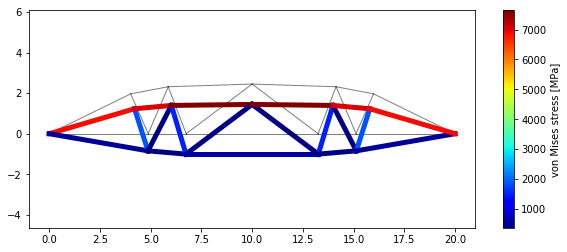

In [24]:
objF1(xopt,plotR=True)